In [83]:
%matplotlib inline

In [84]:
import pandas as pd
import datetime
import numpy as np
import pylab as plt
import scipy
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge, BayesianRidge
from sklearn.preprocessing import normalize
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import ShuffleSplit
import random
from __future__ import print_function
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

np.random.seed(9876789)
# from sklearn.decomposition import PCA

In [85]:
data = pd.read_csv("barro_data.csv")
country_list = pd.read_csv("../data_source/country_code_list.csv", index_col='country')
data.head()

,code,year,gini_DS,quality,GDP_PWT,GDP_PC_PWT,gov_consumption_WB,years_schooling,democracy_index,GDP_MP_WB,GDP_growth_WB,inflation_WB,fertility_WB,dummy_africa,dummy_latin_america,openness
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.820,0,0,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.655,0,0,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.471,0,0,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.271,0,0,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.059,0,0,NaN


We only data keep posterior to 1960. We also remove the countries that do not appear in the list of countries. 

In [86]:
data = data.query('year >= 1955')
data = data.query("code in " + str(country_list['code'].values.tolist()))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13856 entries, 0 to 20928
Data columns (total 16 columns):
code                   13856 non-null object
year                   13856 non-null float64
gini_DS                2527 non-null float64
quality                2528 non-null object
GDP_PWT                9640 non-null float64
GDP_PC_PWT             9640 non-null float64
gov_consumption_WB     9158 non-null float64
years_schooling        2222 non-null float64
democracy_index        8257 non-null float64
GDP_MP_WB              9907 non-null float64
GDP_growth_WB          9876 non-null float64
inflation_WB           7968 non-null float64
fertility_WB           12026 non-null float64
dummy_africa           13856 non-null float64
dummy_latin_america    13856 non-null float64
openness               9501 non-null float64
dtypes: float64(14), object(2)
memory usage: 1.8 MB


# Bad quality data

In his study, Barro change 48 observations quality to 'accept' (cf. note 11), these observations have been gathered in the file added_observations.csv.

In [87]:
added_obs = pd.read_csv("added_observations.csv", names=['country', 'year'])
for row in added_obs.iterrows():
    for year in (np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]) + row[1]['year']):
        added_obs.loc[len(added_obs)] = [row[1]['country'], year]
added_obs['code'] = added_obs['country'].map(lambda x: country_list.loc[x]['code'])
len(data[data['quality']=='accept'])

676

In [88]:
for obs in added_obs.iterrows():
    try:
        data.loc[(obs[1]['code'], obs[1]['year']), 'quality'] = 'accept'
    except KeyError:
        None
len(data[data['quality']=='accept'])

1188

Here, we also make sure that is only one line of data for each couple year, country

In [89]:
data = data[data['quality'].isnull() | data['quality'].map(lambda x: x=='accept')]
del data['quality']
data = data.groupby(['code', 'year'], as_index=True).mean().dropna(how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11637 entries, (ABW, 1960.0) to (ZWE, 2014.0)
Data columns (total 13 columns):
gini_DS                676 non-null float64
GDP_PWT                7580 non-null float64
GDP_PC_PWT             7580 non-null float64
gov_consumption_WB     7352 non-null float64
years_schooling        1647 non-null float64
democracy_index        6248 non-null float64
GDP_MP_WB              8055 non-null float64
GDP_growth_WB          8094 non-null float64
inflation_WB           6485 non-null float64
fertility_WB           10051 non-null float64
dummy_africa           11637 non-null float64
dummy_latin_america    11637 non-null float64
openness               7671 non-null float64
dtypes: float64(13)
memory usage: 1.2 MB


# Resampling the data

Gather the rows by time periods and compute the mean on those periods

In [90]:
sample = data.reset_index(level=0).query("year < 1965").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1960] * len(sample)
re_data = sample
sample = data.reset_index(level=0).query("1965 < year <= 1975").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1970] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1975 < year <= 1985").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1980] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1985 < year <= 1995").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [1990] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("1995 < year <= 2005").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [2000] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
sample = data.reset_index(level=0).query("2005 < year").groupby('code', as_index=False).mean()
sample.loc[:, 'year'] = [2010] * len(sample)
re_data = pd.concat([sample, re_data], axis=0)
re_data = re_data.set_index(['code', 'year']).sort_index()
re_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1241 entries, (ABW, 1960) to (ZWE, 2010)
Data columns (total 13 columns):
gini_DS                249 non-null float64
GDP_PWT                895 non-null float64
GDP_PC_PWT             895 non-null float64
gov_consumption_WB     884 non-null float64
years_schooling        857 non-null float64
democracy_index        790 non-null float64
GDP_MP_WB              942 non-null float64
GDP_growth_WB          957 non-null float64
inflation_WB           773 non-null float64
fertility_WB           1183 non-null float64
dummy_africa           1241 non-null float64
dummy_latin_america    1241 non-null float64
openness               909 non-null float64
dtypes: float64(13)
memory usage: 135.7 KB


# Ploting the data

The effect of resampling is OK

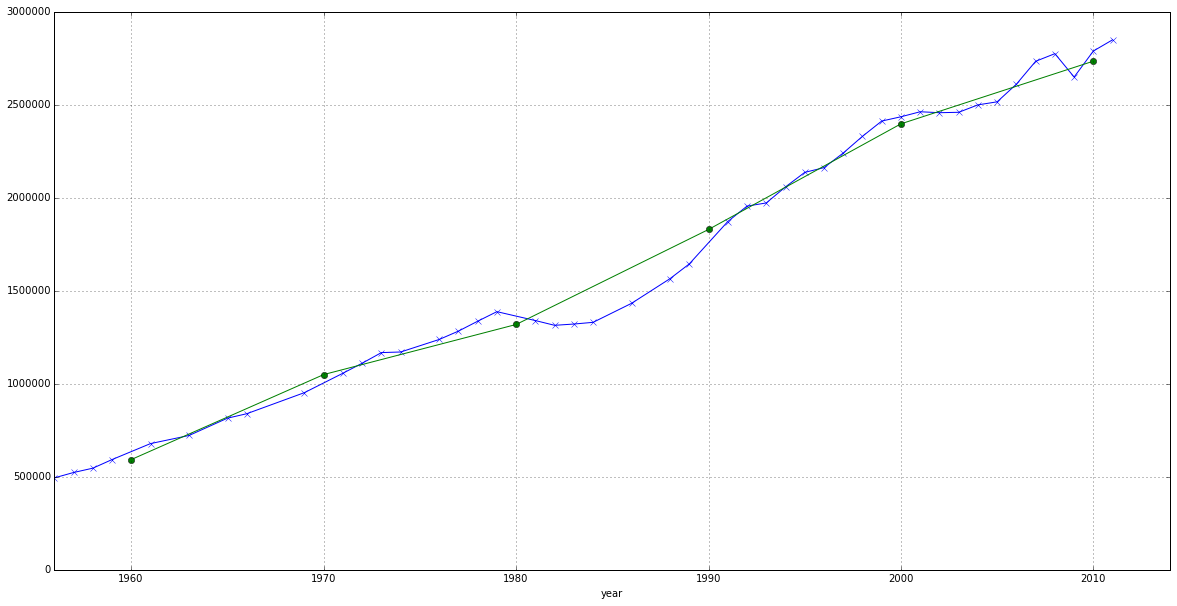

In [91]:
country = 'DEU'
plt.figure(figsize=(20,10))
data.loc['DEU']['GDP_PWT'].plot(marker='x')
re_data.loc['DEU']['GDP_PWT'].plot(marker='o')

<matplotlib.colorbar.Colorbar instance at 0x7fe4d95678c0>

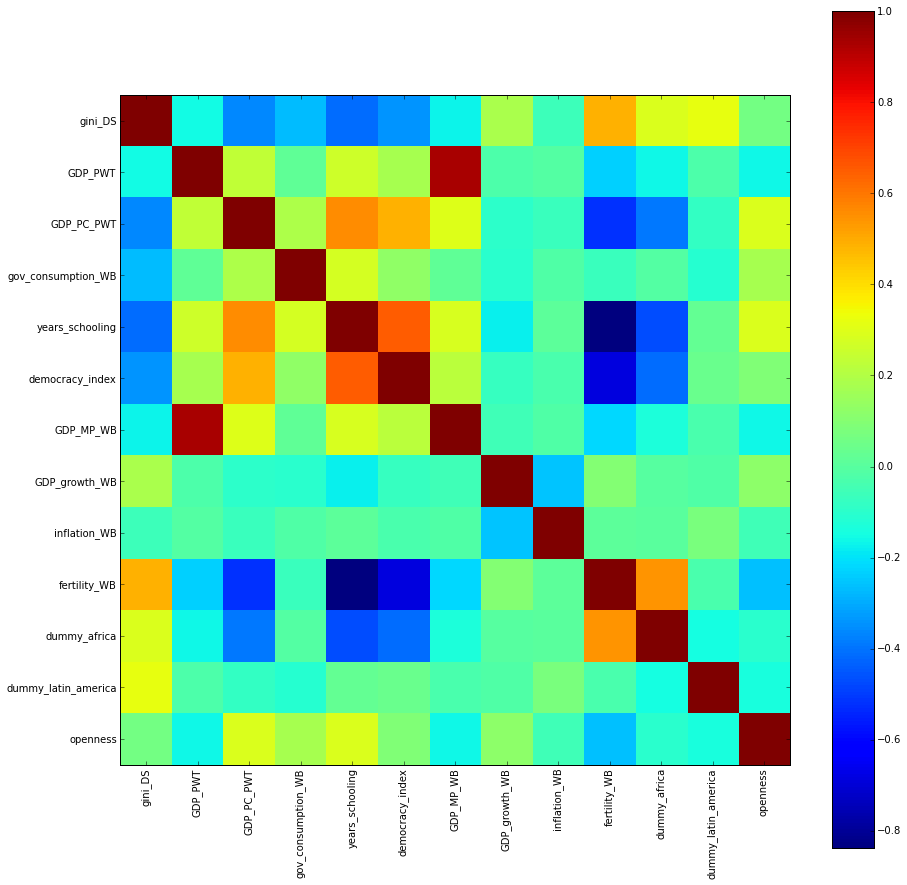

In [92]:
correlations = re_data.corr(min_periods=50)
fig = plt.figure(figsize=(15,15))
plt.imshow(correlations, interpolation='nearest')
plt.xticks(range(0, len(re_data.columns)), re_data.columns, rotation='vertical')
plt.yticks(range(0, len(re_data.columns)), re_data.columns, rotation='horizontal')
plt.colorbar()
# plt.savefig("graphs/correlations_variables.png")

# Regressions

## First regression without the gini coefficient

In [93]:
regression_data = re_data.loc[:, ["GDP_PC_PWT", "gov_consumption_WB", "democracy_index", 
                        "inflation_WB", "years_schooling", "fertility_WB", "GDP_growth_WB"]]
regression_data.loc[:, 'log(GDP)'] = regression_data['GDP_PC_PWT'].apply(np.log)
regression_data.loc[:, 'log(GDP)^2'] = regression_data['log(GDP)']**2
regression_data.loc[:, 'log(fertility)'] = regression_data['fertility_WB'].apply(np.log)
regression_data.loc[:, 'democracy_index^2'] = regression_data['democracy_index']**2
regression_data.dropna(how='any', inplace=True)
X = regression_data.loc[:, ["log(GDP)", 'log(GDP)^2', "gov_consumption_WB", "democracy_index", 
                     'democracy_index^2', "inflation_WB", "years_schooling", 'log(fertility)']]
Y = regression_data.loc[:, "GDP_growth_WB"]

In [94]:
X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm)
all_results = model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     12.35
Date:                Tue, 23 Feb 2016   Prob (F-statistic):           6.95e-16
Time:                        11:35:46   Log-Likelihood:                -1001.2
No. Observations:                 418   AIC:                             2020.
Df Residuals:                     409   BIC:                             2057.
Df Model:                           8                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -12.9236      7.421     -1.741      0.082       -27.512     1.665
log(GDP)               4.270

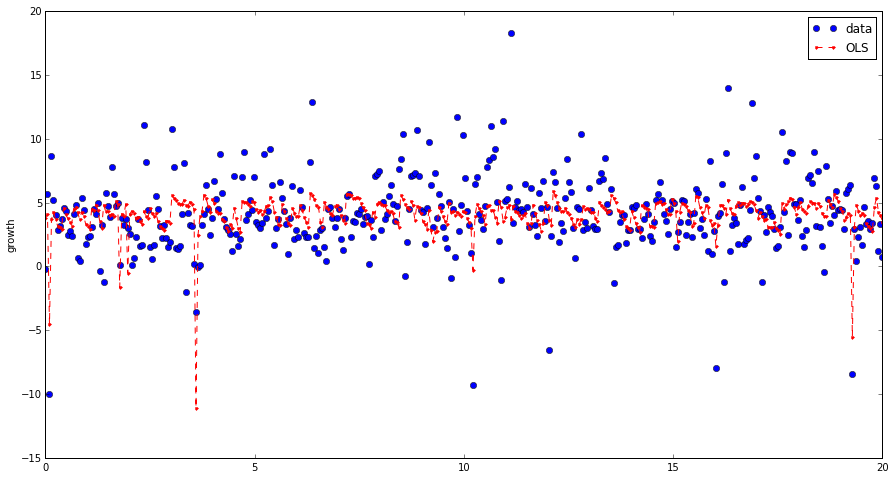

In [95]:
prstd, iv_l, iv_u = wls_prediction_std(all_results)
x = np.linspace(0, 20, len(X))
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, Y, 'o', label="data")
ax.plot(x, all_results.fittedvalues, 'r--.', label="OLS")
plt.ylabel("growth")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### Three stages least-squares

In [96]:
coef_se = pd.concat([all_results.params, all_results.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = all_results.rsquared
coef_se.loc["Nbr obse", "coef"] = all_results.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990', '2000']:
    X_i = X.query("year == " + str(year))
    Y_i = pd.DataFrame(Y).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                  1970                  1980  \
                         coef         SE       coef         SE       coef   
const              -21.931466  35.325126 -72.918796  23.429317  -7.880469   
log(GDP)             8.019789   8.678747  18.139635   5.633564   4.395990   
log(GDP)^2          -0.518209   0.538631  -1.039600   0.337945  -0.304747   
gov_consumption_WB  -0.003703   0.133716   0.054536   0.079561   0.080987   
democracy_index     -0.238054   0.107530  -0.087815   0.115160  -0.106710   
democracy_index^2    0.004801   0.002971   0.000160   0.002994   0.000153   
inflation_WB        -0.049635   0.022281   0.009004   0.015924  -0.003091   
years_schooling      0.315096   0.257578   0.026737   0.267003   0.057552   
log(fertility)      -1.269996   1.343769   0.401308   1.457814  -2.742146   
R^2                  0.303008        NaN   0.251175        NaN   0.151780   
Nbr obse            43.000000        NaN  66.000000        NaN  78.000000   

                                     1990                   2000             \
                           SE        coef         SE        coef         SE   
const               19.134048   -7.295147  17.133670   31.301309  11.340932   
log(GDP)             4.387858    1.597720   4.070413   -5.234395   2.533867   
log(GDP)^2           0.251151   -0.023133   0.241584    0.270991   0.143149   
gov_consumption_WB   0.061709   -0.063503   0.062265   -0.075551   0.047243   
democracy_index      0.108354    0.043423   0.107676   -0.061634   0.066213   
democracy_index^2    0.002663   -0.000577   0.002445    0.000267   0.001628   
inflation_WB         0.001996   -0.003864   0.000697   -0.026071   0.010170   
years_schooling      0.223789   -0.385732   0.214765    0.111699   0.147287   
log(fertility)       1.571578    1.680111   1.329770   -1.033455   0.826204   
R^2                       NaN    0.331199        NaN    0.153415        NaN   
Nbr obse                  NaN  111.000000        NaN  120.000000        NaN   

                           all            
                          coef        SE  
const               -12.923625  7.421330  
log(GDP)              4.270572  1.741478  
log(GDP)^2           -0.236226  0.102459  
gov_consumption_WB   -0.047240  0.028617  
democracy_index      -0.017867  0.043767  
democracy_index^2     0.000203  0.001100  
inflation_WB         -0.004579  0.000576  
years_schooling      -0.167281  0.091029  
log(fertility)        0.198754  0.537595  
R^2                   0.194582       NaN  
Nbr obse            418.000000       NaN

## Scatter plots growth vs Gini

In [97]:
reg_data_gini = re_data.loc[:, ["GDP_PC_PWT", "gov_consumption_WB", "democracy_index", 
                        "inflation_WB", "years_schooling", "fertility_WB", "GDP_growth_WB", "gini_DS"]]
reg_data_gini.loc[:, 'log(GDP)'] = reg_data_gini['GDP_PC_PWT'].apply(np.log)
reg_data_gini.loc[:, 'log(GDP)^2'] = reg_data_gini['log(GDP)']**2
reg_data_gini.loc[:, 'log(fertility)'] = reg_data_gini['fertility_WB'].apply(np.log)
reg_data_gini.loc[:, 'democracy_index^2'] = reg_data_gini['democracy_index']**2
reg_data_gini.dropna(how='any', inplace=True)
X_gini = reg_data_gini.loc[:, ["log(GDP)", 'log(GDP)^2', "gov_consumption_WB", "democracy_index", 
                     'democracy_index^2', "inflation_WB", "years_schooling", 'log(fertility)', 'gini_DS']]
Y_gini = reg_data_gini.loc[:, "GDP_growth_WB"]

First we plot the growth w.t.r to the gini coefficient

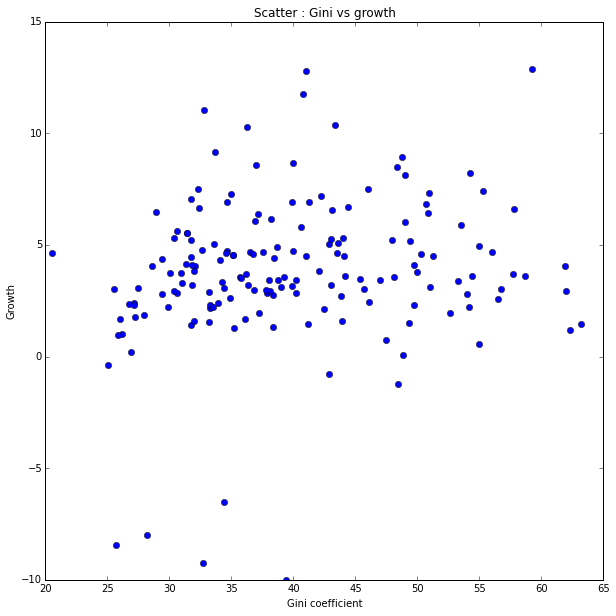

In [98]:
plt.figure(figsize=(10,10))
plt.plot(X_gini["gini_DS"], Y_gini, 'o')
plt.xlabel("Gini coefficient")
plt.ylabel("Growth")
plt.title("Scatter : Gini vs growth")

Then, we plot the unexplained part of the growth w.t.r to the gini coefficient

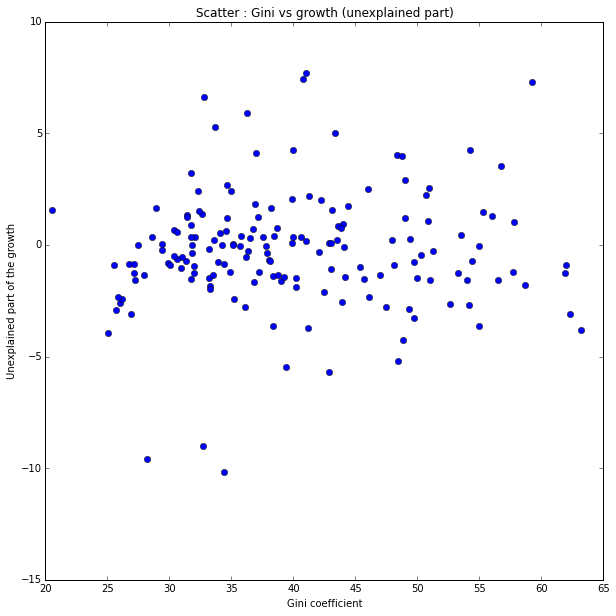

In [99]:
unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
               for point in X_gini.index]
plt.figure(figsize=(10,10))
plt.plot(X_gini["gini_DS"], unexplained, 'o')
plt.xlabel("Gini coefficient")
plt.ylabel("Unexplained part of the growth")
plt.title("Scatter : Gini vs growth (unexplained part)")

Then the unexplained part of growth w.r.t gini for low and high values of the GDP

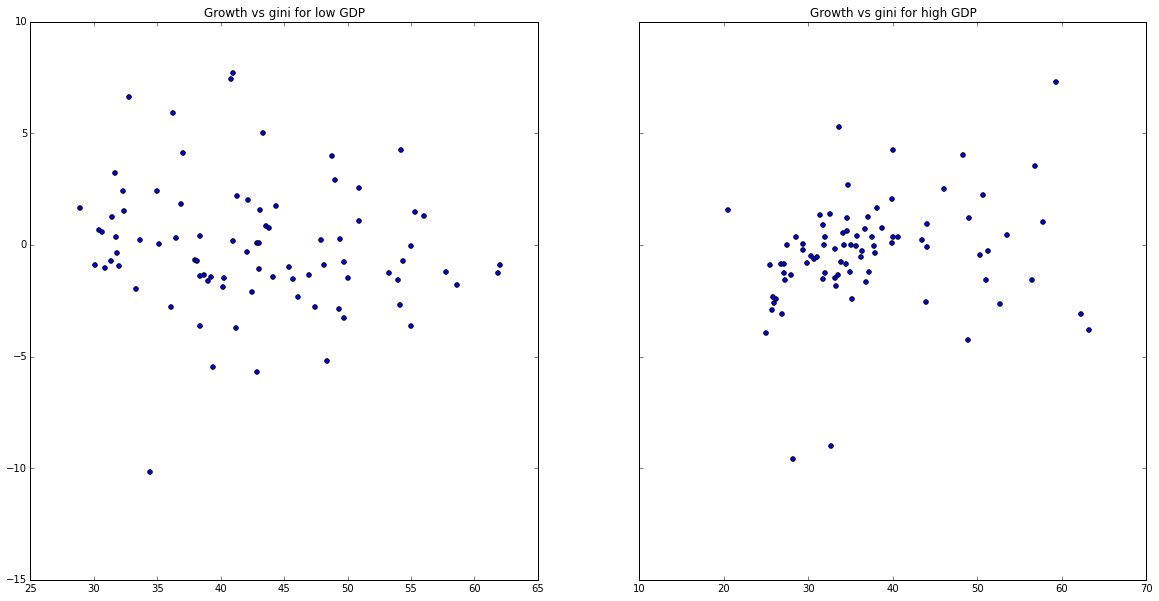

In [100]:
med_GDP = X_gini['log(GDP)'].median()
high_unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
                    for point in X_gini[X_gini['log(GDP)'] > med_GDP].index]
low_unexplained = [Y.loc[point] - np.dot(all_results.params, np.insert(X.loc[point].values, 0, 1))
                    for point in X_gini[X_gini['log(GDP)'] < med_GDP].index]
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharey=True)
ax1.scatter(X_gini[X_gini['log(GDP)'] < med_GDP]['gini_DS'], low_unexplained)
ax1.set_title("Growth vs gini for low GDP")
ax2.scatter(X_gini[X_gini['log(GDP)'] > med_GDP]['gini_DS'], high_unexplained)
ax2.set_title("Growth vs gini for high GDP")

## Regressions with the gini coef

In [101]:
X_sm = sm.add_constant(X_gini)
model_gini = sm.OLS(Y_gini, X_sm)
all_results_gini = model_gini.fit()
print(all_results_gini.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     12.28
Date:                Tue, 23 Feb 2016   Prob (F-statistic):           1.39e-14
Time:                        11:36:07   Log-Likelihood:                -388.01
No. Observations:                 166   AIC:                             796.0
Df Residuals:                     156   BIC:                             827.1
Df Model:                           9                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -34.2184     15.946     -2.146      0.033       -65.717    -2.720
log(GDP)               9.454

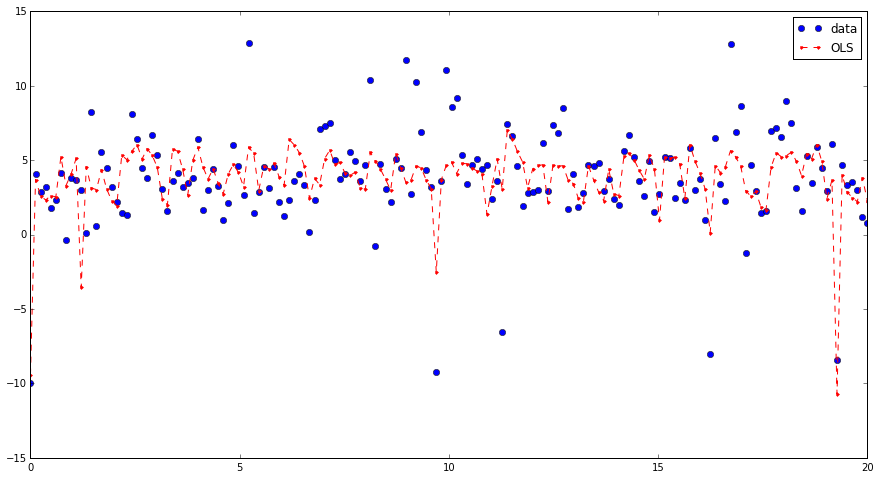

In [102]:
prstd, iv_l, iv_u = wls_prediction_std(all_results_gini)
x = np.linspace(0, 20, len(X_gini))
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, Y_gini, 'o', label="data")
ax.plot(x, all_results_gini.fittedvalues, 'r--.', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### Three stage least squares

In [103]:
coef_se = pd.concat([all_results_gini.params, all_results_gini.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = all_results_gini.rsquared
coef_se.loc["Nbr obse", "coef"] = all_results_gini.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990']:
    X_i = X_gini.query("year == " + str(year))
    Y_i = pd.DataFrame(Y_gini).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                    1970                  1980  \
                         coef          SE        coef         SE       coef   
const              -27.468488  104.130134 -154.734301  50.616404 -43.800577   
log(GDP)            12.581966   26.972859   39.847715  12.196173  14.259695   
log(GDP)^2          -0.756205    1.604081   -2.380803   0.733960  -0.859194   
gov_consumption_WB  -0.403008    0.302348    0.080980   0.133273   0.038946   
democracy_index     -0.086503    0.273420   -0.155862   0.125992  -0.245736   
democracy_index^2   -0.004087    0.008504    0.002245   0.003452   0.001907   
inflation_WB        -0.050367    0.023170    0.024034   0.018174  -0.010754   
years_schooling      0.059113    0.604070   -0.011536   0.284129   0.074032   
log(fertility)      -5.630412    2.202033   -0.956046   2.426641  -2.390873   
gini_DS             -0.068452    0.216979   -0.066132   0.075582  -0.143967   
R^2                  0.856955         NaN    0.445561        NaN   0.369210   
Nbr obse            13.000000         NaN   35.000000        NaN  45.000000   

                                    1990                    all             
                           SE       coef         SE        coef         SE  
const               30.413516 -14.579768  23.766523  -34.218418  15.946353  
log(GDP)             7.450562   4.064219   5.543949    9.454458   3.887883  
log(GDP)^2           0.441974  -0.217967   0.330777   -0.524671   0.235656  
gov_consumption_WB   0.098845  -0.157869   0.073378   -0.127234   0.050554  
democracy_index      0.117505   0.100099   0.116764   -0.030598   0.065157  
democracy_index^2    0.002894  -0.001164   0.002703    0.000482   0.001646  
inflation_WB         0.017145  -0.006541   0.000963   -0.007105   0.000894  
years_schooling      0.243743  -0.214643   0.227426   -0.206166   0.141087  
log(fertility)       1.797793   0.566559   1.678360    0.489051   0.952913  
gini_DS              0.062925   0.044293   0.039805   -0.014388   0.028305  
R^2                       NaN   0.544363        NaN    0.414757        NaN  
Nbr obse                  NaN  73.000000        NaN  166.000000        NaN

### Regression with Gini and without the fertility

In [104]:
cols_list = X_gini.keys().tolist()
cols_list.remove("log(fertility)")
X_sm = sm.add_constant(X_gini[cols_list])
model_gini = sm.OLS(Y_gini, X_sm)
all_results_gini = model_gini.fit()
print(all_results_gini.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP_growth_WB   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     13.85
Date:                Tue, 23 Feb 2016   Prob (F-statistic):           4.04e-15
Time:                        11:36:15   Log-Likelihood:                -388.15
No. Observations:                 166   AIC:                             794.3
Df Residuals:                     157   BIC:                             822.3
Df Model:                           8                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                -33.0375     15.742     -2.099      0.037       -64.132    -1.943
log(GDP)               9.415

# Kuznets curve

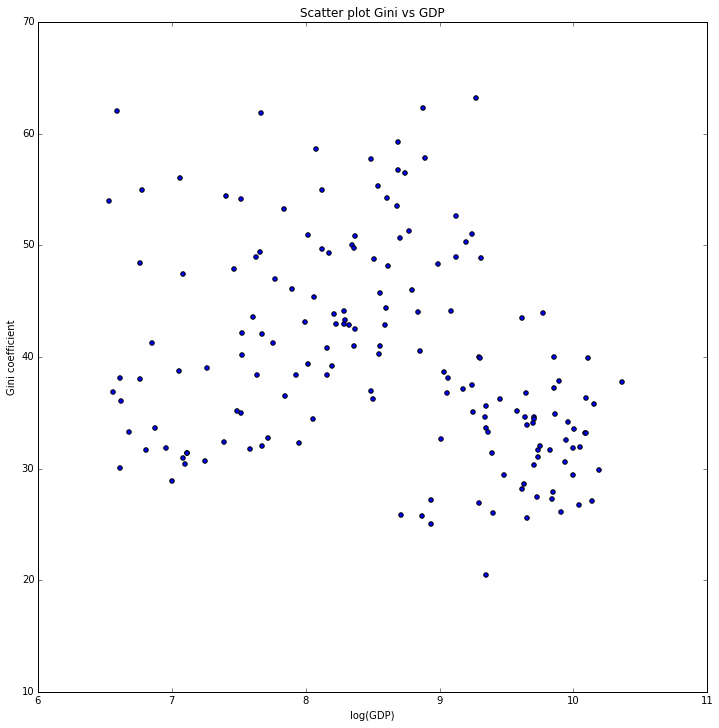

In [105]:
plt.figure(figsize=(12,12))
plt.scatter(X_gini['log(GDP)'], X_gini['gini_DS'])
plt.xlabel("log(GDP)")
plt.ylabel("Gini coefficient")
plt.title("Scatter plot Gini vs GDP")

# Determinants of inequality (regression on the Gini coefficient)

In [106]:
reg_data_gini = re_data.loc[:, ["GDP_PC_PWT", "years_schooling", "dummy_africa", "dummy_latin_america", 
                                "democracy_index", "openness", "gini_DS"]]
reg_data_gini.loc[:, 'log(GDP)'] = reg_data_gini['GDP_PC_PWT'].apply(np.log)
reg_data_gini.loc[:, 'log(GDP)^2'] = reg_data_gini['log(GDP)']**2
reg_data_gini.loc[:, 'openness*log(GDP)'] = reg_data_gini['openness'] * reg_data_gini['log(GDP)']
reg_data_gini.dropna(how='any', inplace=True)
X_ineq = reg_data_gini.loc[:, ["log(GDP)", 'log(GDP)^2', "years_schooling", "dummy_africa", 
                               "dummy_latin_america", "democracy_index", "openness",  'openness*log(GDP)']]
Y_ineq = reg_data_gini.loc[:, "gini_DS"]

In [107]:
X_sm = sm.add_constant(X_ineq)
model_gini = sm.OLS(Y_ineq, X_sm)
ineq_results = model_gini.fit()
print(ineq_results.summary())

                            OLS Regression Results                            
Dep. Variable:                gini_DS   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     20.12
Date:                Tue, 23 Feb 2016   Prob (F-statistic):           9.71e-22
Time:                        11:36:17   Log-Likelihood:                -659.50
No. Observations:                 195   AIC:                             1337.
Df Residuals:                     186   BIC:                             1366.
Df Model:                           8                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                 -72.4637     42.624     -1.700      0.091      -156.553    11.625
log(GDP)               22

### Three stage least squares

In [108]:
coef_se = pd.concat([ineq_results.params, ineq_results.bse], axis=1, keys=["coef", "SE"])
coef_se.loc["R^2", "coef"] = ineq_results.rsquared
coef_se.loc["Nbr obse", "coef"] = ineq_results.nobs
all_coefs = {"all": coef_se}
for year in ['1960', '1970', '1980', '1990']:
    X_i = X_ineq.query("year == " + str(year))
    Y_i = pd.DataFrame(Y_ineq).query("year == " + str(year))
    X_sm = sm.add_constant(X_i)
    model = sm.OLS(Y_i, X_sm)
    results = model.fit()
    coef_se = pd.concat([results.params, results.bse], axis=1, keys=["coef", "SE"])
    coef_se.loc["R^2", "coef"] = results.rsquared
    coef_se.loc["Nbr obse", "coef"] = results.nobs
    all_coefs[year] = coef_se
all_coef = pd.concat([all_coefs[y] for y in np.sort(all_coefs.keys())], axis=1, keys=[y for y in np.sort(all_coefs.keys())])
all_coef

1960                      1970              \
                             coef            SE        coef          SE   
Nbr obse             1.700000e+01           NaN   42.000000         NaN   
R^2                  7.047093e-01           NaN    0.614280         NaN   
const                         NaN           NaN -296.900240  125.910605   
democracy_index     -2.681933e-01  3.421103e-01   -0.097778    0.145284   
dummy_africa        -7.241410e-13  4.117954e-13    5.486219    4.198079   
dummy_latin_america  1.294224e+01  7.142464e+00    8.638013    4.012002   
log(GDP)             8.857439e-01  4.345090e+00   75.093072   31.069216   
log(GDP)^2           6.738925e-01  5.216616e-01   -4.005771    1.924706   
openness             1.901520e+02  1.078969e+02  117.670812   58.060930   
openness*log(GDP)   -2.070411e+01  1.240409e+01  -13.574371    6.685306   
years_schooling     -3.197134e+00  1.379194e+00   -1.530337    0.782213   

                          1980                  1990                    all  \
                          coef         SE       coef         SE        coef   
Nbr obse             52.000000        NaN  83.000000        NaN  195.000000   
R^2                   0.526984        NaN   0.413970        NaN    0.463944   
const               -87.394965  87.332219 -16.101895  66.819263  -72.463668   
democracy_index      -0.241416   0.120556  -0.150300   0.136595   -0.172400   
dummy_africa          2.580104   3.271779   4.800515   3.020632    3.895898   
dummy_latin_america  10.060830   3.964871  13.054757   3.541947   11.102135   
log(GDP)             24.446899  21.810240   8.931685  16.157102   22.754931   
log(GDP)^2           -1.055062   1.355535  -0.198521   0.984518   -1.006390   
openness             76.055748  33.699619  58.955119  23.012206   61.665245   
openness*log(GDP)    -8.113581   3.629086  -6.095451   2.464991   -6.552684   
years_schooling      -0.848988   0.675263  -1.462381   0.620820   -1.500842   

                                
                            SE  
Nbr obse                   NaN  
R^2                        NaN  
const                42.624209  
democracy_index       0.071653  
dummy_africa          1.722889  
dummy_latin_america   2.052911  
log(GDP)             10.520516  
log(GDP)^2            0.650155  
openness             15.259630  
openness*log(GDP)     1.657701  
years_schooling       0.318266

# Resampling the data

In [8]:
period = "10AS"
re_data = pd.DataFrame()
data.index.levels[1]
for country in set(data.index.levels[0].values):
    sel = data.loc[country]
    sel['year'] = sel.index
    sel.index = sel.index.map(lambda x: datetime.datetime(int(x), 1, 1, 0, 0, 0))
    sel = sel.resample(period)
    sel['code'] = [country] * len(sel)
    re_data = pd.concat([re_data, sel], axis=0)
re_data = re_data.sort_index()
re_data = re_data[~re_data['year'].isnull()]

In [9]:
# re_data['year'] = re_data.index.map(lambda x: x.year)
re_data = re_data.set_index(['code', 'year'])
re_data = re_data.sort_index()
re_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1221 entries, (ABW, 1964.5) to (ZWE, 2009.61538462)
Data columns (total 10 columns):
gini_DS               274 non-null float64
GDP_PWT               890 non-null float64
GDP_PC_PWT            890 non-null float64
gov_consumption_WB    869 non-null float64
years_schooling       849 non-null float64
democracy_index       357 non-null float64
GDP_MP_WB             922 non-null float64
GDP_growth_WB         944 non-null float64
inflation_WB          766 non-null float64
fertility_WB          1176 non-null float64
dtypes: float64(10)
memory usage: 104.9 KB


In [12]:
def RMSE(pred, real):
    return np.sqrt(np.mean([x**2 for x in pred - real]))

In [51]:
model = linear_model.LinearRegression(normalize=True, fit_intercept=True)
# grid_search = RandomizedSearchCV(model, {'alpha': [0] * 20}, cv=4, scoring='mean_squared_error')
print "Shape of the explanatory variables : ", X.shape
print "Shape of the output variable : ", Y.shape

Shape of the explanatory variables :  (208, 8)
Shape of the output variable :  (208,)


Root mean square error :  2.67560940389
Relative RMSE :  0.613051491408


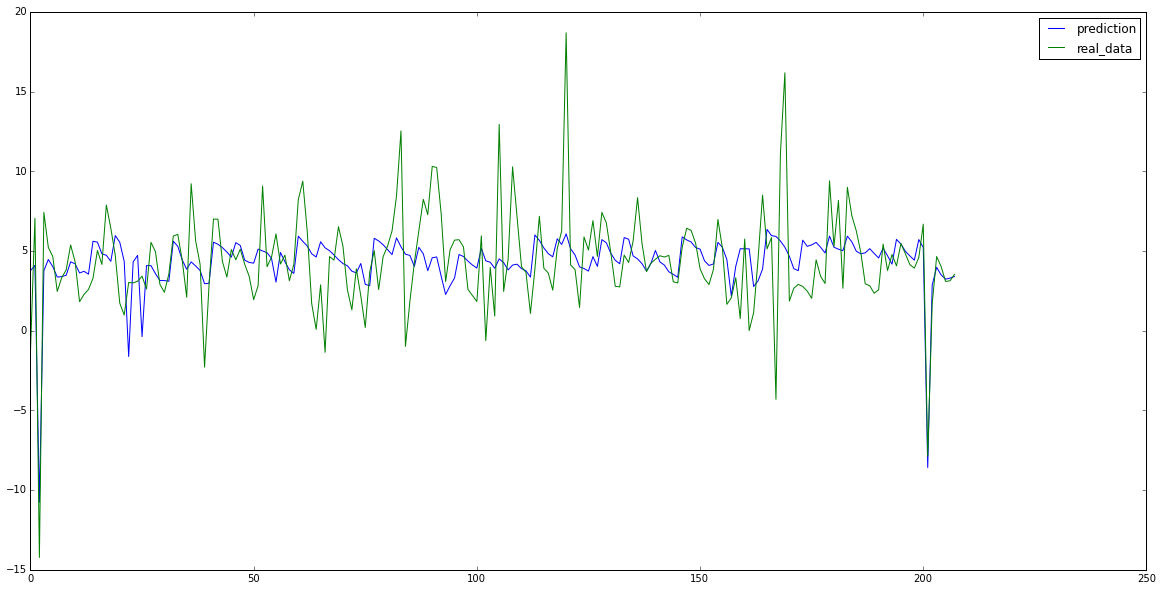

In [52]:
model.fit(X, Y)
train_RMSE = RMSE(model.predict(X), Y)
# print "Parameter : ", grid_search.best_params_
print "Root mean square error : ", train_RMSE
print "Relative RMSE : ", train_RMSE / Y.mean()
plt.figure(figsize=(20,10))
plt.plot(model.predict(X), label="prediction")
plt.plot(Y, label='real_data')
plt.legend()

In [53]:
MSE

7.1588856821929818

In [50]:
MSE = np.mean((Y - model.predict(X))**2)
var_est = MSE * np.diag(np.linalg.pinv(np.dot(X,X.T)))
SE_est = np.sqrt(var_est)
SE_est

array([           nan,            nan,   502.59635697,   642.24797921,
         295.33292249,            nan,    47.20865173,            nan,
         699.41557906,  2925.16886868,            nan,            nan,
         522.34929813,   176.72553534,            nan,            nan,
                  nan,   443.14702046,            nan,            nan,
                  nan,            nan,   280.60150185,   123.69759275,
         166.77069161,   185.1636977 ,            nan,            nan,
                  nan,   439.11326599,            nan,   553.54952816,
                  nan,   217.58435604,            nan,   114.99952246,
         120.52689669,            nan,   181.32023333,            nan,
         190.77207941,            nan,            nan,    49.53426017,
                  nan,            nan,            nan,   188.39890581,
                  nan,            nan,            nan,            nan,
                  nan,            nan,   248.09055805,            nan,
      

In [16]:
for var, coef in zip(X.keys(), model.coef_):
    print var, " : ", coef
print "R^2 : ", model.score(X, Y)
print "Root mean square error : ", RMSE(model.predict(X), Y)
print "Relative RMSE : ", RMSE(model.predict(X), Y) / Y.mean()

log(GDP)  :  -0.961631555485
log(GDP)^2  :  0.0184827373108
gov_consumption_WB  :  -0.0503489711758
democracy_index  :  -0.00534177600746
democracy_index^2  :  0.00045100309488
inflation_WB  :  -0.0043063581239
years_schooling  :  -0.168635557528
log(fertility)  :  0.48480709634
R^2 :  0.290883616387
Root mean square error :  2.67560940389
Relative RMSE :  0.613051491408


As in the paper, calculating the R^2 value on each period

Group the rows according to which decade they belong to

In [17]:
for decade in [1970, 1980, 1990, 2000, 2010]:
    X_sel = X.query(str(decade - 5) + " >= year < " + str(decade + 5))
    Y_sel = pd.DataFrame(Y).query(str(decade - 5) + " >= year < " + str(decade + 5))
    model.fit(X_sel, Y_sel)
    print "Decade = ", decade
    for var, coef in zip(X_sel.keys(), model.coef_[0]):
        print var, " : ", coef
    print "R^2 : ", model.score(X_sel, Y_sel)
    print "Number of points : ", len(X_sel)
    print "\n\n"

Decade =  1970
log(GDP)  :  1.62101780137
log(GDP)^2  :  -0.0340682674123
gov_consumption_WB  :  0.0947026313686
democracy_index  :  -0.23964042075
democracy_index^2  :  0.00300784301477
inflation_WB  :  0.153241031553
years_schooling  :  0.145933923389
log(fertility)  :  -2.48889536984
R^2 :  0.210556361303
Number of points :  24



Decade =  1980
log(GDP)  :  1.07253226599
log(GDP)^2  :  -0.0190523889066
gov_consumption_WB  :  0.0674683973201
democracy_index  :  -0.0988340591554
democracy_index^2  :  0.00112516478346
inflation_WB  :  -0.0918046244869
years_schooling  :  0.0402149351559
log(fertility)  :  0.16025422859
R^2 :  0.0920335470468
Number of points :  57



Decade =  1990
log(GDP)  :  1.10214130861
log(GDP)^2  :  -0.0215306368825
gov_consumption_WB  :  0.0203561217829
democracy_index  :  -0.0185531514051
democracy_index^2  :  -0.000103678946207
inflation_WB  :  -0.0363617429693
years_schooling  :  -0.0986755914831
log(fertility)  :  0.338135532908
R^2 :  0.145553064815
Numbe

In [190]:
str(decade - 5) + " >= year < " + str(decade + 5)

'2005 >= year < 2015'

/usr/local/lib/python2.7/dist-packages/pandas/core/index.py:631: FutureWarning: scalar indexers for index type MultiIndex should be integers and not floating point
  type(self).__name__),FutureWarning)


TypeError: the label [2012.5] is not a proper indexer for this index type (MultiIndex)

In [200]:
X.index.levels[1].max()

2012.5

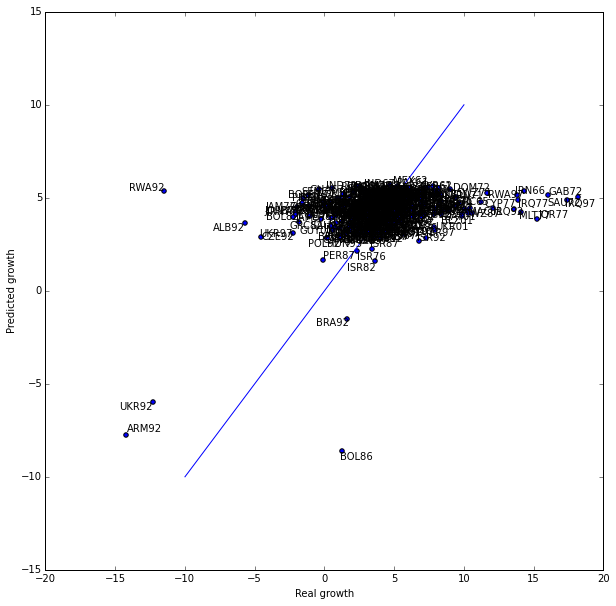

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.scatter(Y, grid_search.predict(X))
for info, x, y in zip(regression_data.index, Y, grid_search.predict(X)):
         plt.annotate(
                     info[0] + str(int(info[1]))[-2:], xy = (x, y),
                     xytext = (random.choice([-1,1]), random.choice([-1,1])),
                     textcoords = 'offset points', ha = random.choice(['right', 'left']), 
                     va = random.choice(['bottom', 'top']), size=10
                     )
plt.xlabel("Real growth", size=10)
plt.ylabel("Predicted growth", size=10)
plt.plot([-10, 10], [-10, 10])
# ax.set_xlim([-2, 7])
# ax.set_ylim([-2, 7])
# plt.savefig("../graphs/figtest.png")

(-2, 7)

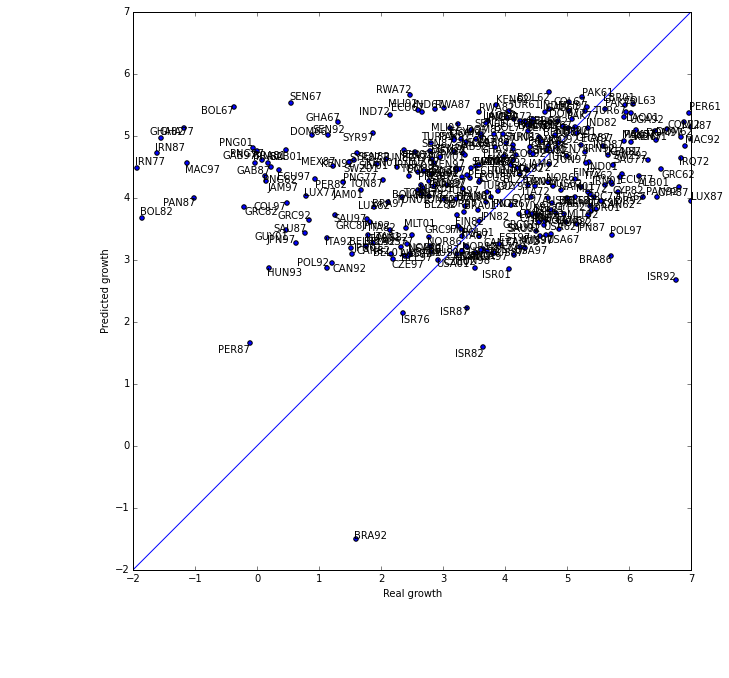

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.scatter(Y, grid_search.predict(X))
for info, x, y in zip(regression_data.index, Y, grid_search.predict(X)):
         plt.annotate(
                     info[0] + str(int(info[1]))[-2:], xy = (x, y),
                     xytext = (random.choice([-1,1]), random.choice([-1,1])),
                     textcoords = 'offset points', ha = random.choice(['right', 'left']), 
                     va = random.choice(['bottom', 'top']), size=10
                     )
plt.xlabel("Real growth", size=10)
plt.ylabel("Predicted growth", size=10)
plt.plot([-10, 10], [-10, 10])
ax.set_xlim([-2, 7])
ax.set_ylim([-2, 7])
# plt.savefig("../graphs/figtest.png")

## Regression with the gini coefficient

Root mean square error :  3.226279408
Relative RMSE :  0.765670982686


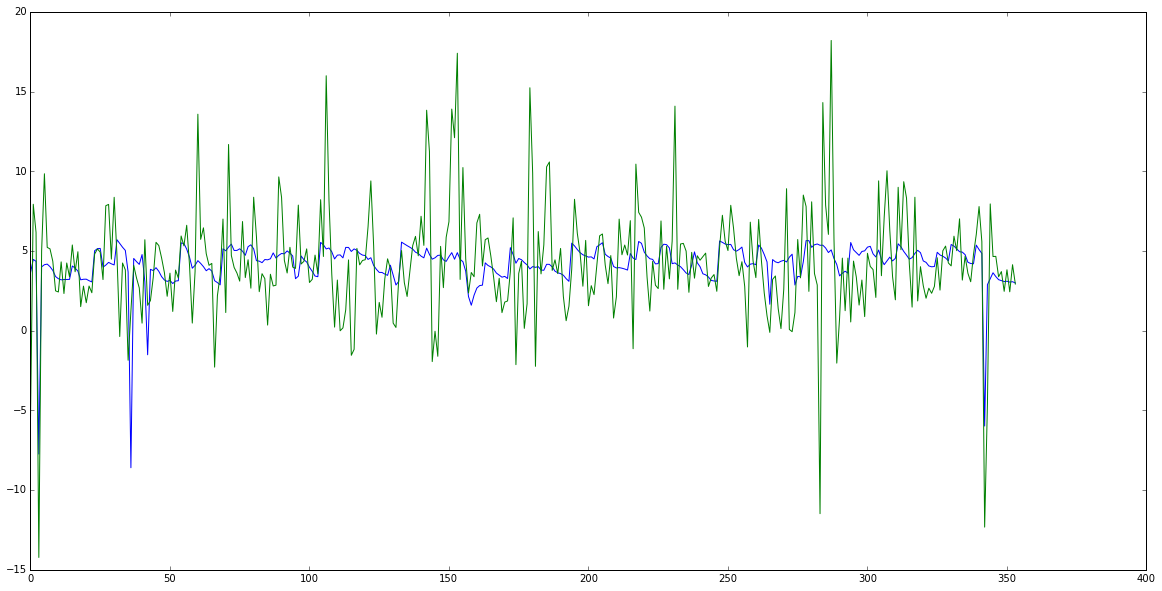

In [216]:
plt.figure(figsize=(20,10))
plt.plot(grid_search.predict(X))
plt.plot(y)

In [197]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ImportError: cannot import name cross_val_predict

In [125]:
re_data[~re_data['gini_DS'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 392 entries, (ARG, 1955-01-01 00:00:00) to (ZWE, 1990-01-01 00:00:00)
Data columns (total 11 columns):
GDP_MP_WB             340 non-null float64
GDP_PC_PWT            373 non-null float64
GDP_PWT               373 non-null float64
GDP_growth_WB         341 non-null float64
democracy_index       187 non-null float64
fertility_WB          367 non-null float64
gini_DS               392 non-null float64
gov_consumption_WB    334 non-null float64
inflation_WB          295 non-null float64
quality               0 non-null object
years_schooling       339 non-null float64
dtypes: float64(10), object(1)
memory usage: 36.8 KB
